# Lab 5 - Computer Vision & Deep Architectures

## Objective

This lab transitions from standard Multi-Layer Perceptrons (MLPs) to Convolutional Neural Networks (CNNs). We will explore manual feature extraction (pooling), build modern architectures (ResNet), and leverage industry-standard pre-trained models (Xception) via Transfer Learning.

### Task 1: Manual Convolution and Pooling
Before training a model, it is helpful to see how these operations "see" an image.

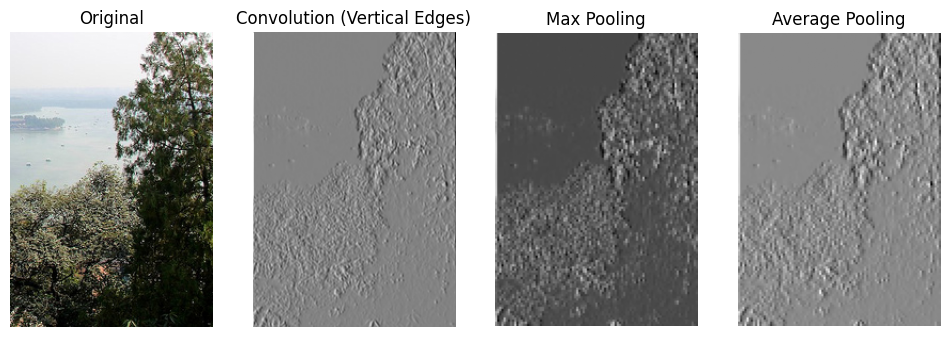

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

# 1. Load a sample image (e.g., a China temple or flower)
china = load_sample_image("china.jpg") / 255.0
image = china[150:450, 450:750] # Crop for detail

# 2. Define a simple 3x3 Vertical Line Filter
# This filter highlights vertical edges
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)

# Reshape for Keras (height, width, channels, num_filters)
kernel_4d = kernel.reshape(3, 3, 1, 1)
image_4d = image[np.newaxis, :, :, 0:1] # Use grayscale channel for simplicity

# 3. Apply Convolution
conv_output = tf.nn.conv2d(image_4d, kernel_4d, strides=[1, 1, 1, 1], padding="SAME")

# 4. Apply Different Pooling Operations
max_pool = tf.nn.max_pool(conv_output, ksize=2, strides=2, padding="VALID")
avg_pool = tf.nn.avg_pool(conv_output, ksize=2, strides=2, padding="VALID")

# 5. Show Results

plt.figure(figsize=(12, 8))
titles = ["Original", "Convolution (Vertical Edges)", "Max Pooling", "Average Pooling"]
imgs = [image, conv_output[0, :, :, 0], max_pool[0, :, :, 0], avg_pool[0, :, :, 0]]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i], cmap="gray" if i > 0 else None)
    plt.title(titles[i])
    plt.axis("off")
plt.show()

### Task 2: CNN vs FCN (Fashion MNIST)
While a Fully Connected Network (FCN) treats images as flat lists of pixels, a CNN preserves spatial relationships.

#### Observation: You should see that the CNN reaches higher accuracy (>90%) faster than your previous FCN because it can recognize patterns (like "sleeves" or "heels") regardless of where they are in the image.

In [5]:
from tensorflow import keras

# Load Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train_full[:-5000] / 255.0
X_valid = X_train_full[-5000:] / 255.0
# CNN expects 4D input: (batch, height, width, channels)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]

# Build CNN
model_cnn = keras.Sequential([
    # 1. Define the input shape FIRST
    keras.layers.Input(shape=(28, 28, 1)),

    # 2. Then add your convolutional and pooling layers
    keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),

    # 3. Flatten and add Dense layers for classification
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_cnn.fit(X_train, y_train_full[:-5000], epochs=5, validation_data=(X_valid, y_train_full[-5000:]))

Epoch 1/5


2026-02-23 14:01:45.516970: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 178s 102ms/step - accuracy: 0.8560 - loss: 0.4025 - val_accuracy: 0.8910 - val_loss: 0.2938
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 165s 96ms/step - accuracy: 0.9008 - loss: 0.2693 - val_accuracy: 0.9008 - val_loss: 0.2682
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 99s 58ms/step - accuracy: 0.9146 - loss: 0.2278 - val_accuracy: 0.9066 - val_loss: 0.2591
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 126s 73ms/step - accuracy: 0.9255 - loss: 0.1982 - val_accuracy: 0.9136 - val_loss: 0.2357
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 144s 84ms/step - accuracy: 0.9362 - loss: 0.1698 - val_accuracy: 0.9160 - val_loss: 0.2376


### Task 3: Implementing ResNet-34
ResNet uses "Skip Connections" to allow gradients to bypass layers, solving the vanishing gradient problem you saw earlier with Sigmoid.

#### Why this structure is famous
Before ResNet, adding 34 layers would cause the Vanishing Gradient problem we discussed earlier. The skip connections (defined in your ResidualUnit class) allow the gradient to "skip" over layers, ensuring that even the 34th layer can receive a strong training signal from the output.

In [7]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

# Build ResNet-34
model_resnet = keras.Sequential()
model_resnet.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))


# ... Add Residual Units here following the ResNet-34 architecture (3, 4, 6, 3)

model_resnet = keras.Sequential()
# Initial Convolution & Max Pooling
model_resnet.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                                     padding="same", use_bias=False))
model_resnet.add(keras.layers.BatchNormalization())
model_resnet.add(keras.layers.Activation("relu"))
model_resnet.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))

# Adding the Residual Stages (3, 4, 6, 3)
prev_filters = 64
for filters in [64, 128, 256, 512]:
    # Determine how many units to add for this stage
    if filters == 64: units = 3
    elif filters == 128: units = 4
    elif filters == 256: units = 6
    else: units = 3

    for i in range(units):
        # Stride of 2 is used to downsample when we increase filter count
        # (Except for the very first 64-filter stage)
        strides = 1 if i > 0 or filters == prev_filters else 2
        model_resnet.add(ResidualUnit(filters, strides=strides))

    prev_filters = filters

# Final Classification Head
model_resnet.add(keras.layers.GlobalAveragePooling2D())
model_resnet.add(keras.layers.Flatten())
model_resnet.add(keras.layers.Dense(10, activation="softmax"))

### Task 4: Transfer Learning with Xception
Transfer Learning allows us to take a model trained on millions of images (ImageNet) and repurpose it for our specific dataset (Flowers).

### Discussion

#### Convolution/Pooling
These operations reduce the spatial size of the data while extracting important features like edges, textures, and patterns. The pooling layers provide translation invariance while downsampling the feature maps.

#### ResNet
The skip connections (residual connections) allow us to train much deeper networks (like 34 or 101 layers) without the accuracy degrading. By learning the residual mapping instead of the direct mapping, gradients can flow directly through the skip connections during backpropagation, solving the vanishing gradient problem.

#### Transfer Learning
This is the most practical way to use AI in industry today. By freezing the pre-trained weights, we keep the "general vision" capabilities of Xception (learned from ImageNet) and only train the final classification layer to distinguish between specific flower types. This approach requires:
- Less data
- Less computational resources
- Less training time
- Often achieves better results than training from scratch

In [ ]:
import tensorflow_datasets as tfds

# 1. Load and Split
(train_set, valid_set, test_set), info = tfds.load("tf_flowers",
                                                  split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
                                                  as_supervised=True, with_info=True)

# 2. Pre-process (Xception expects 299x299)
def preprocess(image, label):
    resized_image = tf.image.resize(image, [299, 299])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

train_set = train_set.shuffle(1000).map(preprocess).batch(32).prefetch(1)
valid_set = valid_set.map(preprocess).batch(32).prefetch(1)

# 3. Create Model using Pre-trained Xception
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(5, activation="softmax")(avg)
model_transfer = keras.Model(inputs=base_model.input, outputs=output)

# 4. Freeze Base Layers
for layer in base_model.layers:
    layer.trainable = False

# 5. Train
model_transfer.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_transfer.fit(train_set, epochs=5, validation_data=valid_set)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5


2026-02-23 14:21:34.985509: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-23 14:21:36.746336: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90935296 exceeds 10% of free system memory.
2026-02-23 14:21:37.074044: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


 8/81 ━━━━━━━━━━━━━━━━━━━━ 14:22 12s/step - accuracy: 0.2552 - loss: 1.5982